In [2]:
#import tensorflow as tf
import cv2
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, train_test_split


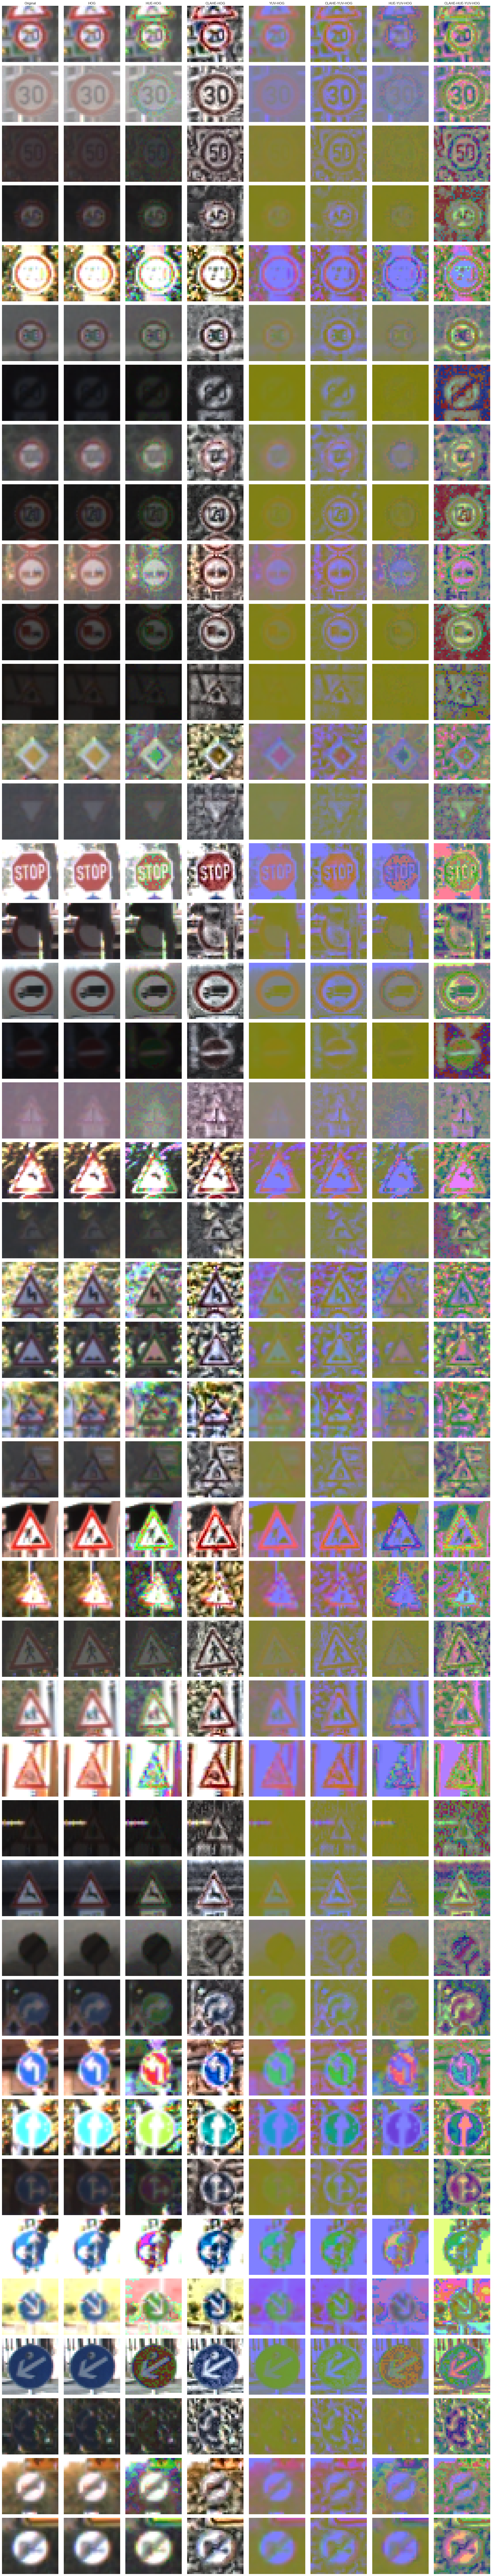

In [39]:
# Define the Annotation class
class Annotation:
    def __init__(self, filename, classId):
        self.filename = filename
        self.classId = classId

# Set up the base paths
base_path = os.path.abspath(os.path.join(os.getcwd()))
data_path = os.path.join(base_path, 'data')
train_images_path = os.path.join(data_path, 'Final_Training', 'Images')

# Function to load annotations
def load_annotations(csv_file, delimiter=';'):
    annotations = []
    df = pd.read_csv(csv_file, delimiter=delimiter)
    for _, row in df.iterrows():
        annotation = Annotation(
            filename=row['Filename'],
            classId=row['ClassId']
        )
        annotations.append(annotation)
    return annotations

# Function to load and preprocess an image
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image {path}")
    return image

def resize_image(image, target_width, target_height):
    return cv2.resize(image, (target_width, target_height))

def apply_CLAHE(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    lab_planes = list(cv2.split(lab_image))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab_image = cv2.merge(lab_planes)
    result_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)
    return result_image

def extract_HUE(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_planes = list(cv2.split(hsv_image))  # Convert the tuple to a list
    hue_channel_equalized = cv2.equalizeHist(hsv_planes[0])
    hsv_planes[0] = hue_channel_equalized
    hsv_image = cv2.merge(hsv_planes)
    hue_channel = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return hue_channel

def compute_HOG(image, kernel_size=3, sigma=0):
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    hog = cv2.HOGDescriptor(
        _winSize=(32, 32),
        _blockSize=(16, 16),
        _blockStride=(8, 8),
        _cellSize=(8, 8),
        _nbins=9
    )
    descriptors = hog.compute(blurred_image)
    return descriptors.reshape(-1, 1)

# Load training annotations
annotations = []
for i in range(43):
    class_str = str(i).zfill(5)
    class_dir = os.path.join(train_images_path, class_str)
    csv_file = os.path.join(class_dir, f'GT-{class_str}.csv')

    if not os.path.exists(csv_file):
        print(f"Error: File does not exist {csv_file}")
        continue

    class_annotations = load_annotations(csv_file)
    for annotation in class_annotations:
        annotation.filename = os.path.join(class_dir, annotation.filename)
    annotations.extend(class_annotations)

# Sample images from each class and show before and after preprocessing
classes = set([ann.classId for ann in annotations])
num_classes = len(classes)

fig, axes = plt.subplots(nrows=num_classes, ncols=8, figsize=(25, num_classes * 3))

for y, cls in enumerate(classes):
    # Find the first image for each class
    sample_ann = next(ann for ann in annotations if ann.classId == cls)
    img_path = sample_ann.filename
    
    # Load and preprocess the image
    img = load_image(img_path)
    img_resized = resize_image(img, 32, 32)
    img_HUE = extract_HUE(img_resized)
    img_CLAHE = apply_CLAHE(img_resized)
    img_YUV = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YUV)
    img_CLAHEYUV = cv2.cvtColor(apply_CLAHE(img_resized), cv2.COLOR_BGR2YUV)
    img_CLAHEYUVHUE = extract_HUE(cv2.cvtColor(apply_CLAHE(img_resized), cv2.COLOR_BGR2YUV))
    img_HUEYUV = cv2.cvtColor(extract_HUE(img_resized), cv2.COLOR_BGR2YUV)
    
    # Compute HOG features
    hog_features = compute_HOG(img_resized)
    hue_hog_features = compute_HOG(img_HUE)
    clahe_hog_features = compute_HOG(img_CLAHE)
    yuv_hog_features = compute_HOG(img_YUV)
    hue_yuv_hog_features = compute_HOG(img_HUEYUV)
    clahe_yuv_hog_features = compute_HOG(img_CLAHEYUV)
    clahe_hue_yuv_hog_features = compute_HOG(img_CLAHEYUVHUE)
    
    # Display original image
    axes[y, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[y, 0].axis('off')
    if y == 0:
        axes[y, 0].set_title('Original')
    
    # Display HOG processed image
    axes[y, 1].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[y, 1].axis('off')
    if y == 0:
        axes[y, 1].set_title('HOG')
    
    # Display HUE-HOG processed image
    axes[y, 2].imshow(cv2.cvtColor(img_HUE, cv2.COLOR_BGR2RGB))
    axes[y, 2].axis('off')
    if y == 0:
        axes[y, 2].set_title('HUE-HOG')
    
    # Display CLAHE-HOG processed image
    axes[y, 3].imshow(cv2.cvtColor(img_CLAHE, cv2.COLOR_BGR2RGB))
    axes[y, 3].axis('off')
    if y == 0:
        axes[y, 3].set_title('CLAHE-HOG')
    
    # Display YUV-HOG processed image
    axes[y, 4].imshow(cv2.cvtColor(img_YUV, cv2.COLOR_BGR2RGB))
    axes[y, 4].axis('off')
    if y == 0:
        axes[y, 4].set_title('YUV-HOG')
    
    # Display CLAHE-YUV-HOG processed image
    axes[y, 5].imshow(cv2.cvtColor(img_CLAHEYUV, cv2.COLOR_BGR2RGB))
    axes[y, 5].axis('off')
    if y == 0:
        axes[y, 5].set_title('CLAHE-YUV-HOG')
    
    # Display HUE-YUV-HOG processed image
    axes[y, 6].imshow(cv2.cvtColor(img_HUEYUV, cv2.COLOR_BGR2RGB))
    axes[y, 6].axis('off')
    if y == 0:
        axes[y, 6].set_title('HUE-YUV-HOG')
    
    # Display CLAHE-HUE-YUV-HOG processed image
    axes[y, 7].imshow(cv2.cvtColor(img_CLAHEYUVHUE, cv2.COLOR_BGR2RGB))
    axes[y, 7].axis('off')
    if y == 0:
        axes[y, 7].set_title('CLAHE-HUE-YUV-HOG')

plt.tight_layout()
plt.show()


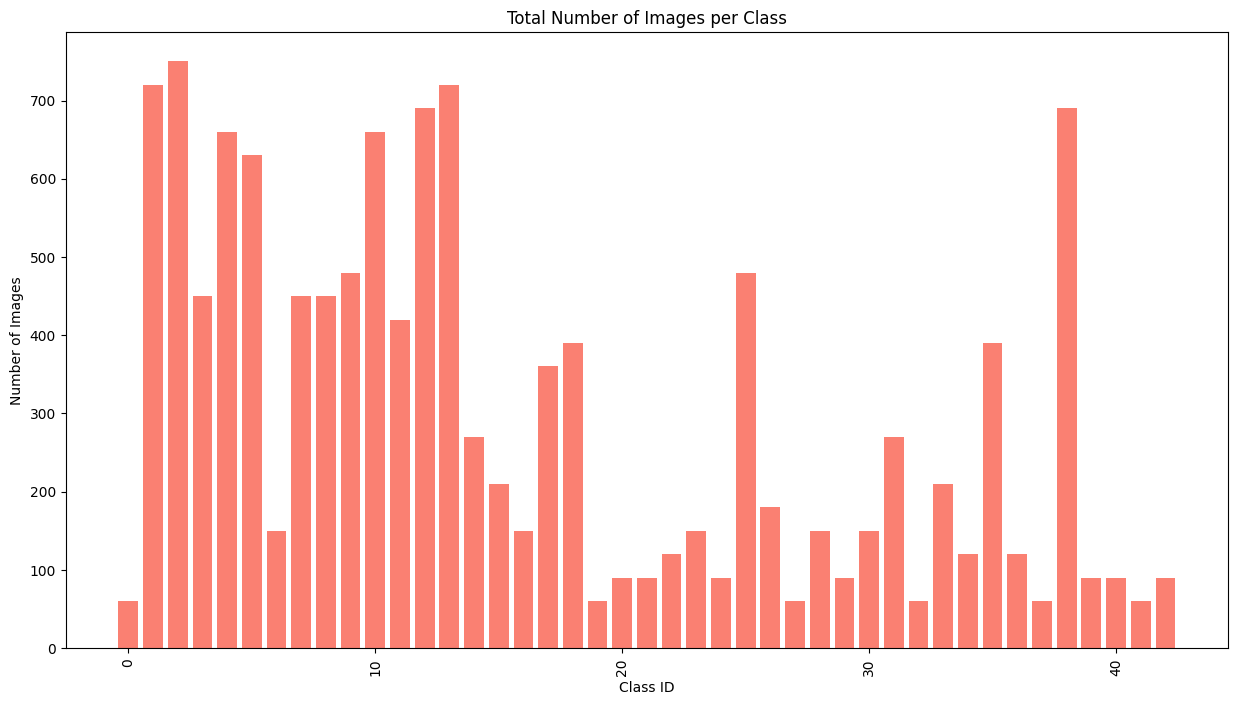

In [13]:
class Annotation:
    def __init__(self, filename, classId):
        self.filename = filename
        self.classId = classId

# Set up the base paths
base_path = os.path.abspath(os.path.join(os.getcwd()))
data_path = os.path.join(base_path, 'data')
train_images_path = os.path.join(data_path, 'Final_Training', 'Images')
test_images_path = os.path.join(data_path, 'Final_Test', 'Images')
test_annotations_path = os.path.join(test_images_path, 'GT-final_test.csv')

# Function to load annotations
def load_annotations(csv_file, delimiter=';'):
    annotations = []
    df = pd.read_csv(csv_file, delimiter=delimiter)
    for _, row in df.iterrows():
        annotation = Annotation(
            filename=row['Filename'],
            classId=row['ClassId']
        )
        annotations.append(annotation)
    return annotations

# Load annotations
annotations = load_annotations(test_annotations_path)

# Count the number of images for each class
class_counts = {}
for annotation in annotations:
    class_id = annotation.classId
    if class_id in class_counts:
        class_counts[class_id] += 1
    else:
        class_counts[class_id] = 1

# Convert the class counts dictionary to a DataFrame
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['ClassId', 'ImageCount'])

# Sort the DataFrame by ClassId
class_counts_df = class_counts_df.sort_values(by='ClassId')

# Plot the bar graph
plt.figure(figsize=(15, 8))
plt.bar(class_counts_df['ClassId'], class_counts_df['ImageCount'], color='salmon')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Define the Annotation class
class Annotation:
    def __init__(self, filename, width, height, x1, y1, x2, y2, classId):
        self.filename = filename
        self.width = width
        self.height = height
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.classId = classId

# Set up the base paths
base_path = os.path.abspath(os.path.join(os.getcwd()))
data_path = os.path.join(base_path, 'data')
train_images_path = os.path.join(data_path, 'Final_Training', 'Images')
test_images_path = os.path.join(data_path, 'Final_Test', 'Images')
test_annotations_path = os.path.join(test_images_path, 'GT-final_test.csv')


In [32]:
# Function to load annotations
def load_annotations(csv_file, delimiter=';'):
    annotations = []
    df = pd.read_csv(csv_file, delimiter=delimiter)
    for _, row in df.iterrows():
        annotation = Annotation(
            filename=row['Filename'],
            width=row['Width'],
            height=row['Height'],
            x1=row['Roi.X1'],
            y1=row['Roi.Y1'],
            x2=row['Roi.X2'],
            y2=row['Roi.Y2'],
            classId=row['ClassId']
        )
        annotations.append(annotation)
    return annotations

# Function to split dataset
def split_dataset(annotations, train_ratio, seed=None):
    if seed:
        np.random.seed(seed)
    np.random.shuffle(annotations)
    train_size = int(train_ratio * len(annotations))
    train_set = annotations[:train_size]
    val_set = annotations[train_size:]
    return train_set, val_set

# Function to load and preprocess an image
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image {path}")
    return image

def resize_image(image, target_width, target_height):
    return cv2.resize(image, (target_width, target_height))

def apply_CLAHE(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    lab_planes = list(cv2.split(lab_image))
    mean, stddev = cv2.meanStdDev(lab_planes[0])
    # dynamic CLAHE based on the std dev
    clipLimit = 2.0
    tileGridSize = (8, 8)
    if stddev[0][0] < 50:  # low contrast
        clipLimit = 4.0
    elif stddev[0][0] < 100:  # medium contrast
        clipLimit = 2.0
    else:  # high contrast
        clipLimit = 1.0
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab_image = cv2.merge(lab_planes)
    result_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)
    return result_image

def compute_HOG(image):
    hog = cv2.HOGDescriptor((32, 32), (16, 16), (8, 8), (8, 8), 9)
    h = hog.compute(image)
    return h.flatten()

def extract_HUE(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_planes = list(cv2.split(hsv_image))  # Convert the tuple to a list
    hue_channel_equalized = cv2.equalizeHist(hsv_planes[0])
    hsv_planes[0] = hue_channel_equalized
    hsv_image = cv2.merge(hsv_planes)
    hue_channel = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return hue_channel

#def random_search_SVM(train_data, train_labels): 
    param_dist = {
        'C': np.linspace(5, 25, 10),
        'gamma': np.linspace(0.05, 0.35, 10) # 10 samples between 0.05 and 0.35
    }
    svm = SVC(kernel='rbf')
    random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=5, cv=3, verbose=2, n_jobs=-1)
    random_search.fit(train_data, train_labels)
    print(f"Best parameters: {random_search.best_params_}")
    return random_search.best_estimator_


def process_images(annotation_set, run_HOG=False, run_CLAHEHOG=False, run_YUVHOG=False, run_HUEHOG=False, run_CLAHEYUVHOG=False, run_CLAHEYUVHUEHOG=False):
    features_HOG = []
    features_CLAHEHOG = []
    features_YUVHOG = []
    features_HUEHOG = []
    features_CLAHEYUVHOG = []
    features_CLAHEYUVHUEHOG = []
    labels = []

    for annotation in annotation_set:
        image_path = annotation.filename
        image = load_image(image_path)
        if image is None:
            continue
        resized_image = resize_image(image, 32, 32)

        if run_HOG:
            features_HOG.append(compute_HOG(resized_image))
        if run_CLAHEHOG:
            clahe_image = apply_CLAHE(resized_image)
            features_CLAHEHOG.append(compute_HOG(clahe_image))
        if run_YUVHOG:
            yuv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YUV)
            features_YUVHOG.append(compute_HOG(yuv_image))
        if run_HUEHOG:
            hue_image = extract_HUE(resized_image)
            features_HUEHOG.append(compute_HOG(hue_image))
        if run_CLAHEYUVHOG:
            clahe_image = apply_CLAHE(resized_image)
            yuv_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2YUV)
            features_CLAHEYUVHOG.append(compute_HOG(yuv_image))
        if run_CLAHEYUVHUEHOG:
            clahe_image = apply_CLAHE(resized_image)
            yuv_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2YUV)
            hue_image = extract_HUE(yuv_image)
            features_CLAHEYUVHUEHOG.append(compute_HOG(hue_image))

        labels.append(annotation.classId)

    return (features_HOG, features_CLAHEHOG, features_YUVHOG, features_HUEHOG, features_CLAHEYUVHOG, features_CLAHEYUVHUEHOG), labels



In [ ]:
#def random_search_SVM(train_data, train_labels): 
#    param_dist = {
#        'C': np.linspace(5, 25, 10),
#        'gamma': np.linspace(0.05, 0.35, 10) # 10 samples between 0.05 and 0.35
#    }
#    svm = SVC(kernel='rbf')
#    random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=5, cv=3, verbose=2, n_jobs=-1)
#    random_search.fit(train_data, train_labels)
#    print(f"Best parameters: {random_search.best_params_}")
#    return random_search.best_estimator_

Initially ran 5-fold 10 iterations on a wider range.

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ....C=11.666666666666668, gamma=0.18333333333333335; total time= 2.4min
[CV] END ....................C=22.77777777777778, gamma=0.35; total time= 2.7min
[CV] END ....................C=22.77777777777778, gamma=0.35; total time= 2.8min
[CV] END ....................C=22.77777777777778, gamma=0.35; total time= 2.8min
[CV] END ....C=11.666666666666668, gamma=0.18333333333333335; total time= 2.0min
[CV] END ....C=20.555555555555557, gamma=0.18333333333333335; total time= 1.9min
[CV] END ....C=20.555555555555557, gamma=0.18333333333333335; total time= 1.9min
[CV] END ....C=11.666666666666668, gamma=0.18333333333333335; total time= 2.0min
[CV] END ....C=20.555555555555557, gamma=0.18333333333333335; total time= 2.0min
[CV] END ....C=20.555555555555557, gamma=0.31666666666666665; total time= 2.3min
[CV] END ....C=20.555555555555557, gamma=0.31666666666666665; total time= 2.3min
[CV] END ....C=20.555555555555557, gamma=0.31666666666666665; total time= 2.3min
[CV] END .................................C=25.0, gamma=0.05; total time= 1.6min
[CV] END .................................C=25.0, gamma=0.05; total time= 1.4min
[CV] END .................................C=25.0, gamma=0.05; total time= 1.4min
Best parameters: {'gamma': 0.35, 'C': 22.77777777777778}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .....C=16.11111111111111, gamma=0.11666666666666667; total time= 2.4min
[CV] END ....C=20.555555555555557, gamma=0.21666666666666667; total time= 2.5min
[CV] END ....C=20.555555555555557, gamma=0.21666666666666667; total time= 2.5min
[CV] END ....C=20.555555555555557, gamma=0.21666666666666667; total time= 2.5min
[CV] END .....C=16.11111111111111, gamma=0.11666666666666667; total time= 2.0min
[CV] END .....C=16.11111111111111, gamma=0.11666666666666667; total time= 2.0min
[CV] END ..................................C=5.0, gamma=0.25; total time= 2.2min
[CV] END ..................................C=5.0, gamma=0.25; total time= 2.2min
[CV] END ..................................C=5.0, gamma=0.25; total time= 2.1min
[CV] END ...................C=5.0, gamma=0.11666666666666667; total time= 2.1min
[CV] END ...................C=5.0, gamma=0.11666666666666667; total time= 2.1min
[CV] END ...................C=5.0, gamma=0.11666666666666667; total time= 2.1min
[CV] END .....C=7.222222222222222, gamma=0.11666666666666667; total time= 1.7min
[CV] END .....C=7.222222222222222, gamma=0.11666666666666667; total time= 1.7min
[CV] END .....C=7.222222222222222, gamma=0.11666666666666667; total time= 1.6min
Best parameters: {'gamma': 0.21666666666666667, 'C': 20.555555555555557}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .....C=13.88888888888889, gamma=0.11666666666666667; total time= 2.0min
[CV] END .....C=20.555555555555557, gamma=0.2833333333333333; total time= 2.4min
[CV] END .....C=20.555555555555557, gamma=0.2833333333333333; total time= 2.4min
[CV] END .....C=20.555555555555557, gamma=0.2833333333333333; total time= 2.4min
[CV] END .....C=13.88888888888889, gamma=0.11666666666666667; total time= 1.8min
[CV] END .....C=13.88888888888889, gamma=0.11666666666666667; total time= 1.8min
[CV] END ..................................C=5.0, gamma=0.05; total time= 2.1min
[CV] END ..................................C=5.0, gamma=0.05; total time= 2.1min
[CV] END ..................................C=5.0, gamma=0.05; total time= 2.3min
[CV] END .....C=18.333333333333336, gamma=0.2833333333333333; total time= 2.3min
[CV] END .....C=18.333333333333336, gamma=0.2833333333333333; total time= 2.2min
[CV] END .....C=18.333333333333336, gamma=0.2833333333333333; total time= 2.2min
[CV] END ....C=20.555555555555557, gamma=0.15000000000000002; total time= 1.4min
[CV] END ....C=20.555555555555557, gamma=0.15000000000000002; total time= 1.2min
[CV] END ....C=20.555555555555557, gamma=0.15000000000000002; total time= 1.1min
Best parameters: {'gamma': 0.2833333333333333, 'C': 20.555555555555557}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=25.0, gamma=0.05; total time= 4.1min
[CV] END .................................C=25.0, gamma=0.05; total time= 4.1min
[CV] END .................................C=25.0, gamma=0.05; total time= 4.1min
[CV] END .....C=9.444444444444445, gamma=0.21666666666666667; total time= 4.3min
[CV] END .....C=22.77777777777778, gamma=0.11666666666666667; total time= 3.7min
[CV] END .....C=9.444444444444445, gamma=0.21666666666666667; total time= 3.9min
[CV] END .....C=9.444444444444445, gamma=0.21666666666666667; total time= 3.9min
[CV] END .....C=22.77777777777778, gamma=0.11666666666666667; total time= 3.7min
[CV] END .....C=22.77777777777778, gamma=0.11666666666666667; total time= 3.8min
[CV] END ....C=20.555555555555557, gamma=0.11666666666666667; total time= 3.8min
[CV] END ....C=20.555555555555557, gamma=0.11666666666666667; total time= 3.8min
[CV] END ....C=20.555555555555557, gamma=0.11666666666666667; total time= 3.8min
[CV] END .....C=13.88888888888889, gamma=0.08333333333333334; total time= 2.7min
[CV] END .....C=13.88888888888889, gamma=0.08333333333333334; total time= 2.7min
[CV] END .....C=13.88888888888889, gamma=0.08333333333333334; total time= 2.6min
Best parameters: {'gamma': 0.21666666666666667, 'C': 9.444444444444445}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .....C=7.222222222222222, gamma=0.18333333333333335; total time= 2.2min
[CV] END ...................C=5.0, gamma=0.21666666666666667; total time= 2.3min
[CV] END ...................C=5.0, gamma=0.21666666666666667; total time= 2.3min
[CV] END ...................C=5.0, gamma=0.21666666666666667; total time= 2.3min
[CV] END .....C=7.222222222222222, gamma=0.18333333333333335; total time= 2.1min
[CV] END .....C=7.222222222222222, gamma=0.18333333333333335; total time= 2.1min
[CV] END ..................................C=5.0, gamma=0.35; total time= 2.3min
[CV] END ..................................C=5.0, gamma=0.35; total time= 2.3min
[CV] END ..................................C=5.0, gamma=0.35; total time= 2.1min
[CV] END ....C=20.555555555555557, gamma=0.31666666666666665; total time= 2.0min
[CV] END ....C=20.555555555555557, gamma=0.31666666666666665; total time= 2.0min
[CV] END ....C=20.555555555555557, gamma=0.31666666666666665; total time= 2.0min
[CV] END ....C=11.666666666666668, gamma=0.31666666666666665; total time= 1.9min
[CV] END ....C=11.666666666666668, gamma=0.31666666666666665; total time= 1.9min
[CV] END ....C=11.666666666666668, gamma=0.31666666666666665; total time= 1.8min
Best parameters: {'gamma': 0.31666666666666665, 'C': 11.666666666666668}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................C=5.0, gamma=0.31666666666666665; total time= 2.9min
[CV] END ....................C=9.444444444444445, gamma=0.35; total time= 2.9min
[CV] END ....................C=9.444444444444445, gamma=0.35; total time= 2.9min
[CV] END ....................C=9.444444444444445, gamma=0.35; total time= 2.9min
[CV] END ...................C=5.0, gamma=0.31666666666666665; total time= 2.2min
[CV] END .....C=7.222222222222222, gamma=0.31666666666666665; total time= 2.2min
[CV] END ...................C=5.0, gamma=0.31666666666666665; total time= 2.2min
[CV] END .....C=7.222222222222222, gamma=0.31666666666666665; total time= 2.2min
[CV] END .....C=9.444444444444445, gamma=0.15000000000000002; total time= 2.0min
[CV] END .....C=9.444444444444445, gamma=0.15000000000000002; total time= 2.0min
[CV] END .....C=9.444444444444445, gamma=0.15000000000000002; total time= 2.0min
[CV] END .....C=7.222222222222222, gamma=0.31666666666666665; total time= 2.2min
[CV] END .....C=16.11111111111111, gamma=0.11666666666666667; total time= 1.6min
[CV] END .....C=16.11111111111111, gamma=0.11666666666666667; total time= 1.6min
[CV] END .....C=16.11111111111111, gamma=0.11666666666666667; total time= 1.6min
Best parameters: {'gamma': 0.35, 'C': 9.444444444444445}
Confusion Matrix:
[[ 46   1   0 ...   0   0   0]
 [  0 448  10 ...   0   0   0]
 [  0   2 454 ...   0   0   0]
 ...
 [  0   0   0 ...  62   0   0]
 [  0   0   0 ...   0  53   0]
 [  0   0   0 ...   0   0  46]]
Accuracy: 0.9821474113746493
Precision: 0.9822520303815316
Recall: 0.9821474113746493
F1 Score: 0.9821513036822811

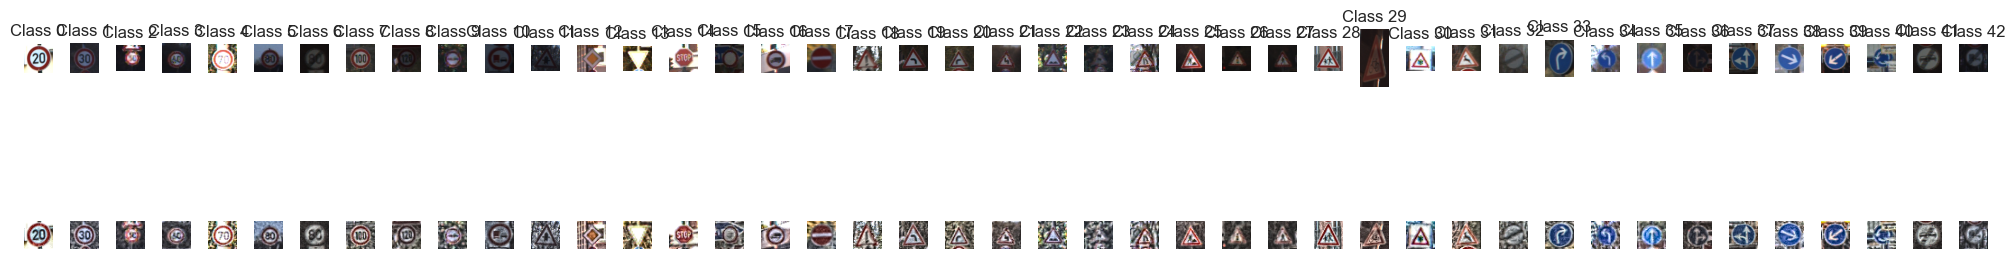

In [34]:
# Sample images from each class and show before and after preprocessing
classes = set([ann.classId for ann in annotations])
num_classes = len(classes)

fig, axes = plt.subplots(nrows=2, ncols=num_classes, figsize=(20, 5))

for y, cls in enumerate(classes):
    # Find the first image for each class
    sample_ann = next(ann for ann in annotations if ann.classId == cls)
    img_path = sample_ann.filename
    
    # Load and preprocess the image
    img = load_image(img_path)
    img_resized = resize_image(img, 32, 32)
    img_CLAHE = apply_CLAHE(img_resized)
    
    # Display original image
    axes[0, y].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, y].axis('off')
    axes[0, y].set_title(f'Class {cls}')
    
    # Display preprocessed image
    axes[1, y].imshow(cv2.cvtColor(img_CLAHE, cv2.COLOR_BGR2RGB))
    axes[1, y].axis('off')

plt.tight_layout()
plt.show()

Validation Feature Extraction Results
  Feature Extraction Method  F1 Score  Accuracy  Precision    Recall
0                       hog  0.987941  0.983423   0.988949  0.987068
1                 clahe-hog  0.982191  0.978959   0.983028  0.981536
2                   yuv-hog  0.994252  0.992094   0.994978  0.993585
3                   hue-hog  0.976770  0.966463   0.979364  0.974585
4             clahe-yuv-hog  0.982211  0.978577   0.983400  0.981367
5         clahe-yuv-hue-hog  0.948339  0.943254   0.951853  0.945501

Test Feature Extraction Results
  Feature Extraction Method  F1 Score  Accuracy  Precision    Recall
0                       hog  0.870827  0.894933   0.894562  0.856204
1                 clahe-hog  0.885807  0.906888   0.903934  0.875642
2                   yuv-hog  0.890902  0.910768   0.917910  0.874569
3                   hue-hog  0.830520  0.858353   0.853133  0.817591
4             clahe-yuv-hog  0.884683  0.905067   0.903625  0.874099
5         clahe-yuv-hue-hog  0.8

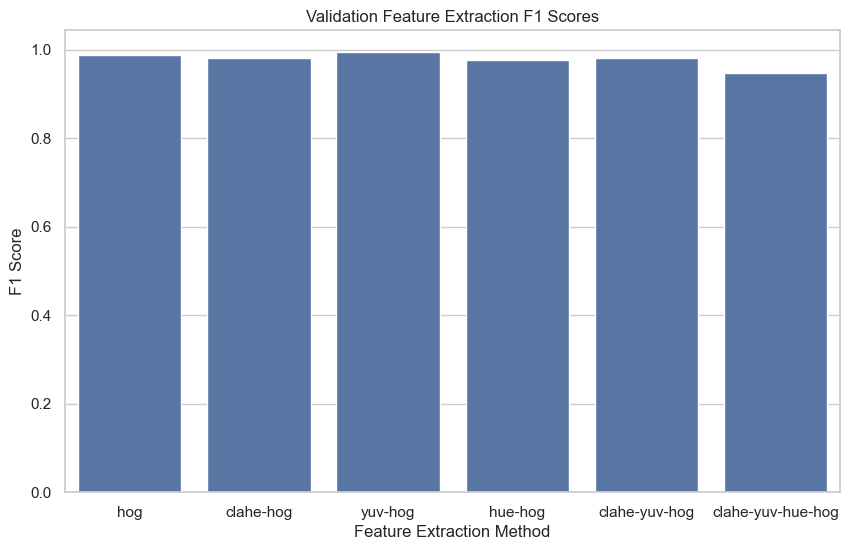

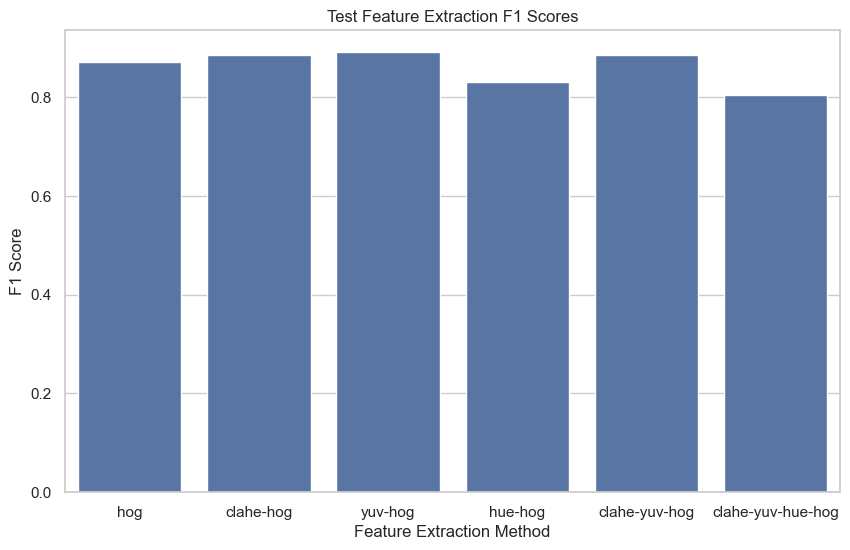

In [22]:
# Data for Validation Feature Extraction
validation_data = {
    'Feature Extraction Method': ['hog', 'clahe-hog', 'yuv-hog', 'hue-hog', 'clahe-yuv-hog', 'clahe-yuv-hue-hog'],
    'F1 Score': [0.987941, 0.982191, 0.994252, 0.97677, 0.982211, 0.948339],
    'Accuracy': [0.983423, 0.978959, 0.992094, 0.966463, 0.978577, 0.943254],
    'Precision': [0.988949, 0.983028, 0.994978, 0.979364, 0.9834, 0.951853],
    'Recall': [0.987068, 0.981536, 0.993585, 0.974585, 0.981367, 0.945501]
}

# Data for Test Feature Extraction
test_data = {
    'Feature Extraction Method': ['hog', 'clahe-hog', 'yuv-hog', 'hue-hog', 'clahe-yuv-hog', 'clahe-yuv-hue-hog'],
    'F1 Score': [0.870827, 0.885807, 0.890902, 0.83052, 0.884683, 0.804654],
    'Accuracy': [0.894933, 0.906888, 0.910768, 0.858353, 0.905067, 0.848298],
    'Precision': [0.894562, 0.903934, 0.91791, 0.853133, 0.903625, 0.828837],
    'Recall': [0.856204, 0.875642, 0.874569, 0.817591, 0.874099, 0.789555]
}

# Create DataFrames
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

# Display DataFrames
print("Validation Feature Extraction Results")
print(validation_df)

print("\nTest Feature Extraction Results")
print(test_df)

# Optionally visualize the results
sns.set(style="whitegrid")

# Plot Validation Results
plt.figure(figsize=(10, 6))
sns.barplot(x="Feature Extraction Method", y="F1 Score", data=validation_df)
plt.title("Validation Feature Extraction F1 Scores")
plt.show()

# Plot Test Results
plt.figure(figsize=(10, 6))
sns.barplot(x="Feature Extraction Method", y="F1 Score", data=test_df)
plt.title("Test Feature Extraction F1 Scores")
plt.show()


In [26]:
# Create tables
validation_table = PrettyTable()
test_table = PrettyTable()

# Add columns
validation_table.field_names = ["Feature Extraction Method", "F1 Score", "Accuracy", "Precision", "Recall"]
test_table.field_names = ["Feature Extraction Method", "F1 Score", "Accuracy", "Precision", "Recall"]

# Add rows
validation_table.add_rows([
    ['hog', 0.987941, 0.983423, 0.988949, 0.987068],
    ['clahe-hog', 0.982191, 0.978959, 0.983028, 0.981536],
    ['yuv-hog', 0.994252, 0.992094, 0.994978, 0.993585],
    ['hue-hog', 0.97677, 0.966463, 0.979364, 0.974585],
    ['clahe-yuv-hog', 0.982211, 0.978577, 0.9834, 0.981367],
    ['clahe-yuv-hue-hog', 0.948339, 0.943254, 0.951853, 0.945501]
])

test_table.add_rows([
    ['hog', 0.870827, 0.894933, 0.894562, 0.856204],
    ['clahe-hog', 0.885807, 0.906888, 0.903934, 0.875642],
    ['yuv-hog', 0.890902, 0.910768, 0.91791, 0.874569],
    ['hue-hog', 0.83052, 0.858353, 0.853133, 0.817591],
    ['clahe-yuv-hog', 0.884683, 0.905067, 0.903625, 0.874099],
    ['clahe-yuv-hue-hog', 0.804654, 0.848298, 0.828837, 0.789555]
])

# Print tables
print("Validation Feature Extraction Results:")
validation_table


Validation Feature Extraction Results:


Feature Extraction Method,F1 Score,Accuracy,Precision,Recall
hog,0.987941,0.983423,0.988949,0.987068
clahe-hog,0.982191,0.978959,0.983028,0.981536
yuv-hog,0.994252,0.992094,0.994978,0.993585
hue-hog,0.97677,0.966463,0.979364,0.974585
clahe-yuv-hog,0.982211,0.978577,0.9834,0.981367
clahe-yuv-hue-hog,0.948339,0.943254,0.951853,0.945501


In [27]:
print("\nTest Feature Extraction Results:")
test_table


Test Feature Extraction Results:


Feature Extraction Method,F1 Score,Accuracy,Precision,Recall
hog,0.870827,0.894933,0.894562,0.856204
clahe-hog,0.885807,0.906888,0.903934,0.875642
yuv-hog,0.890902,0.910768,0.91791,0.874569
hue-hog,0.83052,0.858353,0.853133,0.817591
clahe-yuv-hog,0.884683,0.905067,0.903625,0.874099
clahe-yuv-hue-hog,0.804654,0.848298,0.828837,0.789555
